In [1]:
from pylab import*
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import pandas as pd
#import chart_studio.plotly as py
#from pydub import AudioSegment # immutable objects
#import mpld3
from scipy import stats
import wavio
import seaborn as sns

import tkinter as tk
from tkinter import filedialog

import glob
import os

# add this package to the installation batch script
# https://pypi.org/project/pyloudnorm/
# pip install pyloudnorm
# pip install soundfile

import pyloudnorm as pyln
import soundfile as sf


#test_dir = r'C:\Users\BA_INTERN\Desktop\!!NEW_RECORDINGS_05-2020!!\ARIA_NoD\FullBand\SineSweeps\SineSweep_Day2-ARIA NoD-2.wav'



C:\Users\BA_INTERN\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def listOfAudioFiles():
    root = tk.Tk()
    dirname = filedialog.askdirectory(title='Please select a directory of WAV files you want to analyze')
    newDirName = os.path.normpath(dirname) # converts tkinter directory path to normal OS path labeling
    w = list(glob.glob(os.path.join(newDirName, '*.wav')))
    nameOfFiles = [None]*len(w)
    rate = [None]*len(w)
    root.destroy()

    #renaming the files brute force
    for i in range(len(w)):
        lastChar_index = w[i].rfind("\\") # finds the index of the last occurrence of the input value - need to change per OS
        temp = w[i][lastChar_index+1:]
        secChar_index = temp.rfind(".")
        realName = temp[:secChar_index]
        nameOfFiles[i] = realName
        #res = re.findall(r'\w')
        #res = re.search('(.WAV|.wav)', fname) # looks for upper or lowercase .wav files
    
    for i in range(len(w)):
        w[i], rate[i] = sf.read(w[i])
    
    return w, rate, nameOfFiles

In [3]:
def pairUp(internalPinkWav, internalPinkRate, internalPinkName, externalPinkWav, externalPinkRate, externalPinkName):
    
    cols = ['Stethoscope and day number', 'Pink Internal LUFS (dB)', 'Pink External LUFS (dB)', 'Delta LUFS']
    df = pd.DataFrame(columns = cols)
    substring = '_'
    for i in range(len(internalPinkName)):
        string1 = internalPinkName[i]
        index1 = string1.find(substring)
        string1 = string1[index1+1:]
        
        for j in range(len(externalPinkName)):
            string2 = externalPinkName[j]
            index2 = string2.find(substring)
            string2 = string2[index2+1:]
            
            if string1 == string2:
                
                meter1 = pyln.Meter(internalPinkRate[i]) # create BS.1770-4 meter
                loudness1 = meter1.integrated_loudness(internalPinkWav[i]) # measure loudness
                #loudness1 = round(loudness1,4)
    
                meter2 = pyln.Meter(externalPinkRate[j]) # create BS.1770-4 meter
                loudness2 = meter2.integrated_loudness(externalPinkWav[j]) # measure loudness
                #loudness2 = round(loudness2,4)
                
                # external pink noise lufs - internal pink noise lufs
                delta = loudness2-loudness1
                
                df = df.append({'Stethoscope and day number': string1,  'Pink Internal LUFS (dB)':loudness1,
                                'Pink External LUFS (dB)':loudness2, 'Delta LUFS':delta  }, ignore_index=True)
                
    root = tk.Tk()
    dirname = filedialog.askdirectory(title='Please select a directory to save your LUFS chart')            
    df.to_csv(dirname+'/'+'LUFS chart.csv')
    root.destroy()
    
    return df


In [50]:
# isolating all the csv files within a massive in vitro file
def massiveLufsChart():
    test_dir = filedialog.askdirectory(title='Please select a directory of in vitro file with all of the LUFS charts')
    listOfCSV = []
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if file.endswith(".csv"):
                 listOfCSV.append(os.path.join(root, file))
                    
    combined_csv = pd.concat([pd.read_csv(f) for f in listOfCSV ])
    del combined_csv['Unnamed: 0']
    combined_csv['index'] = range(len(combined_csv['Delta LUFS']))
    combined_csv = combined_csv.set_index('index')
    
    root = tk.Tk()
    dirname = filedialog.askdirectory(title='Please select a directory to save your large LUFS chart')            
    combined_csv.to_csv(dirname+'/'+'Compiled LUFS chart.csv')
    root.destroy()
    
    return combined_csv

In [47]:
# read in wav files from pink internal
print("Please choose internal pink noise wav file directory")
internalPinkWav, internalPinkRate, internalPinkName = listOfAudioFiles()

# read in wav files from pink external
print("Please choose external pink noise wav file directory")
externalPinkWav, externalPinkRate, externalPinkName = listOfAudioFiles()

# save dataframe of lufs
print("Please choose where to save LUFS csv file")
yes = pairUp(internalPinkWav, internalPinkRate, internalPinkName, externalPinkWav, externalPinkRate, externalPinkName)


Please choose internal pink noise wav file directory
Please choose external pink noise wav file directory


In [54]:
compiled = massiveLufsChart()


In [55]:
compiled


,Stethoscope and day number,Pink Internal LUFS (dB),Pink External LUFS (dB),Delta LUFS
index,,,,
0,Day1-ARIA NoD-2_205-775,-29.239360,-35.450598,-6.211238
1,Day2-ARIA NoD-2_205-775,-29.279330,-36.240382,-6.961052
2,Day3-ARIA NoD-2_205-775,-29.118780,-35.596322,-6.477542
3,Day4-ARIA NoD-2_205-775,-27.762838,-22.210801,5.552038
4,Day5-ARIA NoD-2_205-775,-27.916069,-30.087297,-2.171228
...,...,...,...,...
313,Day1-Thinklabs-9,-24.080876,-28.651638,-4.570762
314,Day2-Thinklabs-11,-24.003046,-30.019488,-6.016442
315,Day3-Thinklabs-11,-24.296303,-28.286973,-3.990671


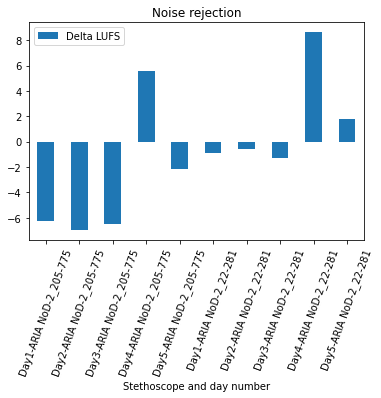

In [61]:
compiled[:10].plot.bar(x="Stethoscope and day number", y="Delta LUFS", rot=70, title="Noise rejection")

#plot.show(block=True)



In [2]:
# using soundfile package
data, rate = sf.read(test_dir)


In [3]:
# pyloudnorm functions
meter = pyln.Meter(rate) # create BS.1770-4 meter
loudness = meter.integrated_loudness(data) # measure loudness
